In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [2]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

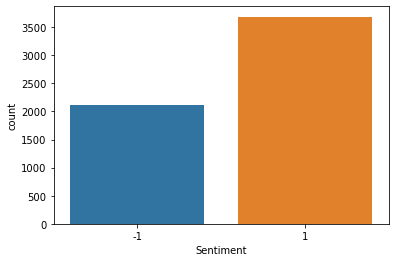

In [3]:
headlines = pd.read_csv('stock_data.csv', sep=',')

import seaborn as sns
sns.countplot(x='Sentiment', data=headlines)

In [7]:
# some data cleaning to change class label "-1" to become "0": 
# improves training accuracy vastly from average 0.02 to average 0.99
headlines['Category']=headlines['Sentiment'].apply(lambda x: 0 if x== "-1" else 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(headlines['Text'], headlines['Category'], stratify = headlines['Category'], random_state=45)

In [9]:
# simple network combining BERT layers with dropout and dense from keras to improve speed 
# (requires much lesser number of epochs: only 5) while having accuracy
# bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# neural network of dropout and dense (LSTM inspiration)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size = 128)

Epoch 1/5
34/34 [==============================] - 539s 16s/step - loss: 0.0011 - accuracy: 0.9998
Epoch 2/5
34/34 [==============================] - 587s 17s/step - loss: 1.7189e-04 - accuracy: 1.0000
Epoch 3/5
34/34 [==============================] - 590s 17s/step - loss: 9.4997e-05 - accuracy: 1.0000
Epoch 4/5
34/34 [==============================] - 577s 17s/step - loss: 6.8457e-05 - accuracy: 1.0000
Epoch 5/5
34/34 [==============================] - 593s 17s/step - loss: 4.0707e-05 - accuracy: 1.0000


In [12]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
# there are only 2 classes, the percentages reflect the degree of confidence of classification between class label "0" (original
# label "-1") and label "1"
print(y_predicted)

# binary classification into either of the 2 classes
y_predicted_binary = np.where(y_predicted >= 0.5, 1, -1)
print(y_predicted_binary)

46/46 [==============================] - 191s 4s/step
[0.99999386 0.9999934  0.99978757 ... 0.9999847  0.9999981  0.9999948 ]
[1 1 1 ... 1 1 1]


In [13]:
print(y_predicted_binary.shape)

(1448,)


In [14]:
print(y_test.shape)

(1448,)


In [15]:
import sklearn as sk

test_acc = sk.metrics.accuracy_score(np.array(y_predicted_binary)[:],
                                    np.array(y_test)[:])
print(test_acc)

1.0


In [16]:
score_test = model.evaluate(X_test, y_test, verbose=1)

46/46 [==============================] - 178s 4s/step - loss: 3.8858e-05 - accuracy: 1.0000


In [17]:
print("Test Score:", score_test[0])
print("Test Accuracy:", score_test[1])

Test Score: 3.885760088451207e-05
Test Accuracy: 1.0
